In [37]:
%pip install opencv-python tqdm

  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.66.4-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset
from cv2 import imread
import matplotlib.pyplot as plt
import io

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import xml.etree.ElementTree as ET
import tqdm


def crop_image(image, bndbox):
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    return image[ymin:ymax, xmin:xmax]

class StanfordDogsDataset(Dataset):
    def __init__(self, root_dir, limit_classes=10000, limit_img_per_class=10000, transform=None):
        self.root_dir = root_dir
        self.img_names = []
        self.bndx = []
        self.breed = []
        self.label_to_idx = dict()
        self.transform = transform

        annotations_dir = os.path.join(self.root_dir, 'annotations', 'Annotation')
        images_dir = os.path.join(self.root_dir, 'images', 'Images')

        annotations = os.listdir(annotations_dir)
        for _, annotation_dir_name in zip(range(limit_classes), annotations):
            category_img_dir = os.path.join(images_dir, annotation_dir_name)
            annotation_dir = os.path.join(annotations_dir, annotation_dir_name)
            images_names = os.listdir(category_img_dir)

            for _, image_name in zip(range(limit_img_per_class), images_names):
                ann = ET.parse(os.path.join(annotation_dir, image_name.split('.')[0])).getroot()
                obj = ann.find('object')
                name = obj.find('name').text
                bndbox = obj.find('bndbox')
                
                if name not in self.label_to_idx:
                    self.label_to_idx[name] = len(self.label_to_idx)


                self.img_names.append(os.path.join(category_img_dir, image_name))
                self.bndx.append(bndbox)
                self.breed.append(name)

        # print(len(self.img_names))

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        ann = self.breed[idx]
        bndbox = self.bndx[idx]

        img = imread(self.img_names[idx])
        img = crop_image(img, bndbox)


        if self.transform:
            img = self.transform(img)

        # print(type(image))

        return img.to(torch.float), self.label_to_idx[ann]

In [98]:
# CNN model
class HashingNet(torch.nn.Module):
    def __init__(self, encoding_size):
        super().__init__()
        self.encoding_size = encoding_size
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, 3, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(1, 3),
            torch.nn.Linear(6272, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, encoding_size),
            torch.nn.Sigmoid(),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(encoding_size, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 6272),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (128,7,7)),

            torch.nn.ConvTranspose2d(128, 64, 3, 2),
            torch.nn.ReLU(),
            torch.nn.Upsample(size=(31,31)),

            torch.nn.ConvTranspose2d(64, 32, 3, 2),
            torch.nn.ReLU(),

            torch.nn.Upsample(size=(127,127)),

            torch.nn.ConvTranspose2d(32, 3, 3, 2),
            torch.nn.Upsample(size=(512,512)),

            torch.nn.ReLU(),
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        if self.training:
            decoded = self.decoder(encoded)
            return decoded
        return encoded
        buff = io.BytesIO()
        torch.save(x, buff)
        buff.seek(0)
        return buff.read()


class Classifier(torch.nn.Module):
    def __init__(self, encoding_size=1024, classes=10):
        super().__init__()
        self.pool = torch.nn.MaxPool2d(2)
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten(1, 3)
        self.sigmoid = torch.nn.Sigmoid()

        self.conv1 = torch.nn.Conv2d(3, 32, 3, 2)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 2)
        self.conv3 = torch.nn.Conv2d(64, 128, 3, 2)
        self.fc1 = torch.nn.Linear(6272, 2048)
        self.fc2 = torch.nn.Linear(2048, encoding_size)

        self.last = torch.nn.Linear(encoding_size, classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        x = self.last(x)

        return x


def accuracy_test(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader[:200]:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total


def train_classifier(model, train_loader, optimizer, epochs=5):
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(tqdm.tqdm(train_loader), 0):
            inputs, labels = data
            # labels = torch.tensor([int(label) for label in labels])
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        acc = accuracy_test(model, train_loader)
        print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 1000}, accuracy: {acc}')
                

def train_autoencoder(model, train_loader, optimizer, epochs=5):
    model.train()
    criterion = torch.nn.L1Loss()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (data, _) in enumerate(tqdm.tqdm(train_loader), 0):
            optimizer.zero_grad()
            outputs = model(data)
            #print(outputs.shape)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 1000}')
        

In [112]:
from torch import nn

def transpose_conv_layer(conv_layer):
    """
    Transpose a pretrained Conv2d layer into a ConvTranspose2d layer.

    Args:
        conv_layer (nn.Conv2d): The pretrained Conv2d layer to transpose.

    Returns:
        nn.ConvTranspose2d: The transposed Conv2d layer as a ConvTranspose2d layer.
    """
    if not isinstance(conv_layer, nn.Conv2d):
        raise TypeError("The provided layer must be an instance of nn.Conv2d")

    # Extract weights and biases
    weights = conv_layer.weight
    biases = conv_layer.bias

    # Initialize a ConvTranspose2d layer
    conv_transpose = nn.ConvTranspose2d(
        in_channels=conv_layer.out_channels,
        out_channels=conv_layer.in_channels,
        kernel_size=conv_layer.kernel_size,
        stride=conv_layer.stride,
        padding=conv_layer.padding,
        output_padding=conv_layer.output_padding if hasattr(conv_layer, 'output_padding') else 0
    )

    # Copy weights and biases into the ConvTranspose2d layer
    # conv_transpose.weight.data = weights.data.T.contiguous()
    print(weights.data.shape)
    print(weights.data.permute(1, 0, 2, 3).contiguous().shape)
    conv_transpose.weight.data = weights.data.clone()
    # conv_transpose.weight.data = weights.data.permute(1, 0, 2, 3).contiguous()
    # conv_transpose.bias.data = biases.data.clone()

    return conv_transpose



def copy_weights_from_classifier(classifier, hashing_net):
    with torch.no_grad():
        # Copy encoder weights
        hashing_net.encoder[0].weight.copy_(classifier.conv1.weight)
        hashing_net.encoder[0].bias.copy_(classifier.conv1.bias)

        hashing_net.encoder[3].weight.copy_(classifier.conv2.weight)
        hashing_net.encoder[3].bias.copy_(classifier.conv2.bias)

        hashing_net.encoder[6].weight.copy_(classifier.conv3.weight)
        hashing_net.encoder[6].bias.copy_(classifier.conv3.bias)

        hashing_net.encoder[10].weight.copy_(classifier.fc1.weight)
        hashing_net.encoder[10].bias.copy_(classifier.fc1.bias)

        hashing_net.encoder[12].weight.copy_(classifier.fc2.weight)
        hashing_net.encoder[12].bias.copy_(classifier.fc2.bias)

        # Copy decoder weights (transposed from encoder weights)
        hashing_net.decoder[0].weight.copy_(classifier.fc2.weight.T)
        # hashing_net.decoder[0].bias.copy_(classifier.fc2.bias)

        hashing_net.decoder[2].weight.copy_(classifier.fc1.weight.T)
        # hashing_net.decoder[2].bias.copy_(classifier.fc1.bias)

        hashing_net.decoder[5] = transpose_conv_layer(classifier.conv3)
        # hashing_net.decoder[5].weight.copy_(classifier.conv3.weight.T)
        # hashing_net.decoder[5].bias.copy_(classifier.conv3.bias)

        hashing_net.decoder[8] = transpose_conv_layer(classifier.conv2)
        # hashing_net.decoder[8].weight.copy_(classifier.conv2.weight.T)
        # hashing_net.decoder[8].bias.copy_(classifier.conv2.bias)

        hashing_net.decoder[11] = transpose_conv_layer(classifier.conv1)
        # hashing_net.decoder[11].weight.copy_(classifier.conv1.weight.T)
        # hashing_net.decoder[11].bias.copy_(classifier.conv1.bias)


In [27]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512))
])

trainset = StanfordDogsDataset('./dogs', limit_classes=10, limit_img_per_class=200, transform=data_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

In [44]:
from torch.utils.data import Subset

print("train dataset size:", len(trainset))
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

classifier = Classifier(encoding_size=64, classes=10)
hashNet = HashingNet(encoding_size=64)

cl_opt = torch.optim.Adam(classifier.parameters(), lr=0.001)
optimizer = torch.optim.Adam(hashNet.parameters(), lr=0.0005)

train dataset size: 1000


In [95]:
train_classifier(classifier, train_loader, cl_opt, epochs=4)

100%|██████████| 63/63 [00:42<00:00,  1.50it/s]


[1, 63] loss: 0.1441956969499588, accuracy: 0.186


100%|██████████| 63/63 [00:48<00:00,  1.30it/s]


[2, 63] loss: 0.12921773970127107, accuracy: 0.229


100%|██████████| 63/63 [00:51<00:00,  1.23it/s]


[3, 63] loss: 0.12126375615596771, accuracy: 0.343


In [110]:
copy_weights_from_classifier(classifier, hashNet)

torch.Size([128, 64, 3, 3])
torch.Size([64, 128, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([32, 64, 3, 3])
torch.Size([32, 3, 3, 3])
torch.Size([3, 32, 3, 3])


In [111]:
train_autoencoder(hashNet, train_loader, optimizer, epochs=4)

  0%|          | 0/63 [00:00<?, ?it/s]


RuntimeError: Given transposed=1, weight of size [128, 64, 3, 3], expected bias to be 1-dimensional with 64 elements, but got bias of size [128] instead

In [99]:
img = trainset[0][0]
img = img[None, :, :, :]
hashNet.eval()
hsh = hashNet(img)
print(hsh)

tensor([[2.2000e-19, 9.9999e-01, 1.0000e+00,  ..., 2.3640e-19, 2.9350e-13,
         2.1071e-19]], grad_fn=<SigmoidBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

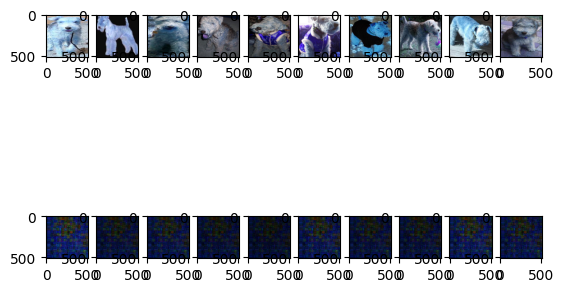

In [100]:
encoded_imgs = []
decoded_imgs = []

fig, ax = plt.subplots(2, 10)

hashNet.train()
for i in range(10):
    img = trainset[i][0]
    img = img[None, :, :, :]
    decoded = hashNet(img)
    decoded = torch.squeeze(decoded)
    # print(type(decoded))
    ax[0][i].imshow(trainset[i][0].permute(1, 2, 0))
    ax[1][i].imshow(decoded.permute(1, 2, 0).detach().numpy())

plt.show()

In [105]:
myHash = ""
hsh_norm = torch.round(hsh.squeeze() * 62 + 48).to(torch.int32)
for i in range(1024):
    let = hsh_norm[i] + 7*int(84 > hsh_norm[i] > 57) + 13*int(83 < hsh_norm[i])
    myHash += chr(let)

In [106]:
hsh_norm[0]

tensor(48, dtype=torch.int32)

In [107]:
print(chr(60))

<


In [108]:
myHash

'0{{0000{0{{0{00000000{{00000000{y0000000000000{00000{0{00z0{{0{0000{{0{0{{000{{{0{{{0000{{m00000{{{{00000000000{00{00000{{{000{0{{000000{0000000000{00{{00{0{00000{0000000{{{{{0000{0000t00{{0{0000{00{{0000{00000{000{{000{{00000{{000{00{{0{0{0{{y{0a{0{0000{0x000{{{0z000000000000{000000000{0{0{00000000000{{{{0{0{0{0000{000{{00{00t000{{{00000{000{000000{{{0{0{000000{00{0{00l{0000000000{0000{000000{{0{00{0{00000{0{{0{0{0{00{{0u00{{{0x{{{0{0000000000{00{{{{{{000{0X0000000000{00000000{{00{{00{000{{{00{0{{y0000{0{00{00{0000000{{00{000B0{{0000{{{{0000{{{0000000000{{{{{{0{0{00000{00{{0{00{0{00000000{000000{{{0{0000000{0{000{{{0000{{00{000{00{{{{00000{{0000{00000000000000{0{000000000{00{000{000{0{000000000{0{{{0{0x00000{00000{0{{{0{000{00000{{0000000{0000000000000000{{000000{00000000000000{00000000{{00{{0{0000{{000{{{{{000{0000000{00{{0000{0{{{00{{00{0000000{00{0000000000000{{0000{000zy00000{0000{{{{{000{0{00{{0{0{0000000000000{0000{00000{00{000{00{w00{00w{00000000{00{0000000{{00{0{000{{0{{000{{